In [1]:
%mkdir /kaggle/working/Utilities
%cp -r /kaggle/input/speeding-transformer-training/*.py /kaggle/working/Utilities

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
%cd ..

/kaggle/working


In [6]:
from Utilities.config import get_config

cfg = get_config()
cfg['batch_size'] = 128
cfg['preload'] = None
cfg['num_epochs'] = 40

from Utilities.dataset import BilingualDataModule
from Utilities.model import build_transformer
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, ModelSummary

In [7]:
datamodule = BilingualDataModule(cfg)
datamodule.setup()

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.
Max length of source sentences: 45
Max length of target sentences: 48


In [8]:
model = build_transformer(
    datamodule.tokenizer_src.get_vocab_size(),
    datamodule.tokenizer_tgt.get_vocab_size(),
    cfg["seq_len"],
    cfg["seq_len"],
    d_model=cfg["d_model"],
)

In [9]:
trainer = pl.Trainer(
    max_epochs=cfg["num_epochs"],
    accelerator="cuda",
    callbacks=[
        ModelCheckpoint(dirpath=cfg['model_folder'], verbose=True,), 
        LearningRateMonitor(logging_interval='step', log_momentum=True),
        ModelSummary(max_depth=0)
    ],
    default_root_dir="Store/",
    fast_dev_run=False,
    check_val_every_n_epoch=2,
    num_sanity_val_steps=10,
    limit_val_batches=1000,
    precision="16-mixed",
    gradient_clip_val=0.5,
    detect_anomaly=False
)

In [10]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,datamodule=datamodule, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

Max length of source sentences: 45
Max length of target sentences: 48
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

EPOCH: 0, Loss: nan


new_lr=0.00199526231496888


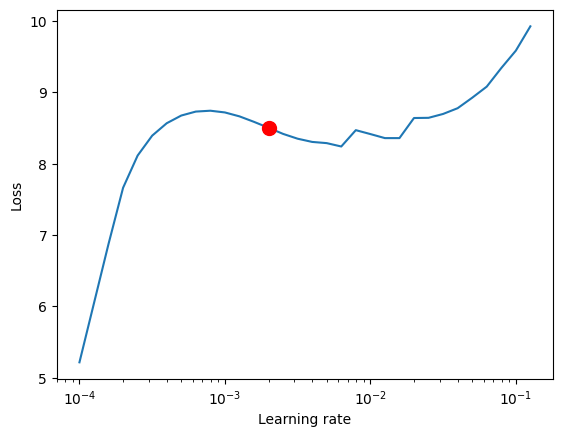

In [11]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [12]:
model.best_lr = new_lr

In [13]:
trainer.fit(model, datamodule)

Max length of source sentences: 45
Max length of target sentences: 48


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--------------------------------------------------------------------------------
SOURCE: 'That's thirty francs Grogeot's imprudence has earned for the town,' said one.
TARGET: – Voilà trente francs que l’imprudence de Grogeot vaut à la commune, disait l’un.
PREDICTED: demeurait demeurait demeurait demeurait demeurait demeurait demeurait demeurait dem

Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
EPOCH: 0, Loss: 6.7699294090271
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | fal

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Dom Claude had barely time to fling himself on the ground in order that he might not be met, stared in the face and recognized by his brother.
TARGET: Dom Claude n’eut que le temps de se jeter à terre pour ne pas être rencontré, regardé en face, et reconnu par son frère.
PREDICTED: Claude avait été presque à se faire à l ’ endroit dans la route de l ’ on ne pouvait pas le visage et de sa figure .
--------------------------------------------------------------------------------
SOURCE: Nobody was there to tell him.
TARGET: Personne n’était là pour le renseigner.
PREDICTED: Rien n ’ était pas le dire .
--------------------------------------------------------------------------------
SOURCE: Maheu was trying to find something to say before leaving, when Étienne again touched his elbow.
TARGET: Maheu cherchait un mot pour partir, lorsque Étienne, de nouveau, le toucha du coude.
PREDICTED: Maheu était à s

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: '"I ask you for a bursary for Julien; he will qualify for it by undergoing the necessary examinations.
TARGET: « Je vous demande pour Julien Sorel une bourse ; il la méritera en subissant les examens nécessaires.
PREDICTED: – Je vous demande une bourse pour Julien ; il par les dames .
--------------------------------------------------------------------------------
SOURCE: It was half-past ten in the evening when the two adventurers disappeared in the darkness.
TARGET: Il était dix heures et demie du soir, quand tous deux disparurent dans l'obscurité.
PREDICTED: Il était dix heures du soir , lorsqu ' on s ' enfonçait dans les deux ténebres .
--------------------------------------------------------------------------------
SOURCE: 'Monsieur has the floor,' he said, indicating the personage with the fatherly air, who was wearing three or four waistcoats.
TARGET: La parole est à monsieur, dit-il en indi

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Alors le prince, après s’être assis, s’est mis à faire la description de chacun de vos salons.
TARGET: Then the Prince took a seat and went into a description of each of your rooms in turn.
PREDICTED: Then the Prince ' s ' , is to be lost , is to think of your age of your age ."
--------------------------------------------------------------------------------
SOURCE: He must begin to think of me.
TARGET: Il faut qu’il se mette en route.
PREDICTED: Il faut me croire .
--------------------------------------------------------------------------------
SOURCE: 'What was that?' said I.
TARGET: --Et qu'est-ce donc? dis-je.
PREDICTED: Qu ’ est - ce que cela ? dis - je .
--------------------------------------------------------------------------------
SOURCE: Thus a month passed, but at the end of that time I could endure it no longer.
TARGET: Un mois se passa ainsi, mais ce fut tout ce que je pus supporter.
P

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: You think so, but you deceiveyourself.
TARGET: Tu ne me pardonnerais pas demain.
PREDICTED: Tu crois , mais tu as tu as .
--------------------------------------------------------------------------------
SOURCE: If only he could have desisted from makingher suffer; but this again he could not, suffering as he did himself.
TARGET: Si seulement il avait pu ne pas lafaire souffrir; mais il ne le pouvait pas non plus, souffrant toujourslui-même.
PREDICTED: Si il n ' eût pu souffrir , mais ce qu ' il souffrait , il ne pouvait se séparer de lui , il ne pouvait se briser .
--------------------------------------------------------------------------------
SOURCE: Captain Nemo was waiting for me.
TARGET: Le capitaine Nemo m'y attendait.
PREDICTED: Le capitaine Nemo m ' attendait .
--------------------------------------------------------------------------------
SOURCE: Their reception from Mr. Bennet, to whom t

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: That evening was delightful for them all, except for the Mayor of Verrieres, who could not forget the growing wealth of his competitors.
TARGET: Cette soirée fut charmante pour tout le monde, excepté pour le maire de Verrières, qui ne pouvait oublier ses industriels enrichis.
PREDICTED: Ce soir - là , le soir , sauf tout le monde de Verrières qui ne pouvait oublier le projet de son tour .
--------------------------------------------------------------------------------
SOURCE: 'Take them in the same carriage,' he had told him.
TARGET: – Emmène-les dans la même voiture, lui avait-il dit.
PREDICTED: – - les même dans la voiture , lui dit - il .
--------------------------------------------------------------------------------
SOURCE: But really, I don't see how, from the description you have, you will be able to recognise your man, even if he is on board the Mongolia."
TARGET: Mais je ne sais vraiment p

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: That depends on the Company."
TARGET: Ça dépend de la Compagnie.
PREDICTED: Cela dépend la Compagnie .
--------------------------------------------------------------------------------
SOURCE: "That is to say," replied d’Artagnan, "that you will wait until I have proved myself worthy of it.
TARGET: -- C'est-à-dire, monsieur, reprit d'Artagnan, que vous attendez que je m'en sois rendu digne.
PREDICTED: -- C ' est à vous dire , dit d ' Artagnan , je vous en , moi - même .
--------------------------------------------------------------------------------
SOURCE: Whatever might be the sailor's opinion, the expedition projected by the engineer was settled for the next day.
TARGET: Quoi qu'en eût le marin, l'exploration, projetée par l'ingénieur, fut maintenue pour le lendemain.
PREDICTED: Qui pouvait donc être le marin de l ' Henrietta , l ' ingénieur fut mis à l ' ingénieur , pendant le lendemain .
------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Pencroft had not struck hard enough, fearing to rub off the phosphorus.
TARGET: «Non, je ne pourrai pas, dit-il, ma main tremble... L'allumette raterait...
PREDICTED: Pencroff n ' avait pas assez dur , de , le phosphore .
--------------------------------------------------------------------------------
SOURCE: "I do not know."
TARGET: – Je n’en sais rien.
PREDICTED: -- Je ne le connais pas .
--------------------------------------------------------------------------------
SOURCE: Heaven preserve me from exaggeration.'
TARGET: Dieu me préserve d’exagérer.
PREDICTED: - moi de moi .
--------------------------------------------------------------------------------
SOURCE: He would have eloped with her, carried her off somewhere, but then both would die of hunger. He risked less in killing the husband.
TARGET: Il l'aurait bien enlevée, emportée quelque part, mais alors ils seraient morts de faim tous deux.

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: I assumed that he was keeping to the pilothouse.
TARGET: Je supposai qu'il se tenait dans la cage du timonier.
PREDICTED: Je pris cette cage qu ' il allait regagner la cage .
--------------------------------------------------------------------------------
SOURCE: Gangrene, in fact, was spreading more and more.
TARGET: La gangrène, en effet, montait de plus en plus.
PREDICTED: , en effet , tout était clos et plus .
--------------------------------------------------------------------------------
SOURCE: They spoke one after the other in a despairing voice, giving expression to their complaints.
TARGET: Ils parlaient l'un apres l'autre, d'une voix désolée, et les doléances commencerent.
PREDICTED: Ils causaient après les autres plaintes d ' une voix désespéré , de leur expression .
--------------------------------------------------------------------------------
SOURCE: This time Zacharie burst out lau

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: This said, Captain Nemo headed to the hatch and disappeared down the ladder.
TARGET: Ceci dit, le capitaine Nemo se dirigea vers le panneau et disparut par l'échelle.
PREDICTED: Ce capitaine Nemo , dit au panneau , disparut vers l ' échelle et disparut .
--------------------------------------------------------------------------------
SOURCE: Chapter 4
TARGET: IV
PREDICTED: 4
--------------------------------------------------------------------------------
SOURCE: Who could foresee what the future would then have in store for the colonists?
TARGET: Or, qui pouvait prévoir ce que l'avenir réservait aux colons?
PREDICTED: Qui pouvait donc espérer ce qui aurait lieu d ' attendre les colons ?
--------------------------------------------------------------------------------
SOURCE: "Then you have been in Paraguay?" asked Candide.
TARGET: Tu as donc été déjà dans le Paraguai? dit Candide.
PREDICTED: Vous av

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "You will come back?" she said, looking at me with haggard eyes.
TARGET: --Tu reviendras? fit-elle en me regardant avec des yeux hagards.
PREDICTED: — Tu ? dit - elle en me regardant , les yeux ….
--------------------------------------------------------------------------------
SOURCE: After searching his coat, 'this is no diplomat,' said the priest: he moved away, and wisely.
TARGET: Son habit fouillé, ce n’est pas là un diplomate, dit le prêtre : il s’éloigna et fit bien.
PREDICTED: Après avoir , son habit , ce n ’ est pas , dit le prêtre ; il s ’ éloigna en courant , et il sourit avec fin .
--------------------------------------------------------------------------------
SOURCE: "And is the written report of the gownsmen to be placed in comparison with the word of honor of a swordsman?" replied Treville haughtily.
TARGET: -- Procès-verbal de gens de robe vaut-il la parole d'honneur, répondit fière

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Then she dropped her arms in discouragement, and remained seated, with lowered head, eyes fixed on the ground, mute and still trembling.
TARGET: Puis elle laissa tomber ses bras découragés, et resta assise, la tête baissée, l’œil fixé à terre, muette, et continuant de trembler.
PREDICTED: Alors elle abaissa ses bras , , se coucha ventre , les yeux fermés et restait immobile sur le sol , et muette .
--------------------------------------------------------------------------------
SOURCE: Do you know Monsieur de Treville, their captain?"
TARGET: Connaissez-vous M. de Tréville, leur capitaine?
PREDICTED: Connaissez - vous M . de Tréville , le capitaine ?
--------------------------------------------------------------------------------
SOURCE: His mother, beaming, went on talking: "And only fancy, I got it for twothousand eight hundred francs a year.
TARGET: Sa mère, radieuse, parlait toujours: --Et figu

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: The only thing they had against him was that he could not take a joke, and grew angry as soon as any one trod on his toes.
TARGET: On ne lui reprochait que de ne pas comprendre la plaisanterie, tout de suite fâché, des qu'on voulait taper sur lui.
PREDICTED: La seule chose qu ' ils l ' avaient eue , qu ' il ne put prendre un mot , et qu ' on se le - champ comme pour lui .
--------------------------------------------------------------------------------
SOURCE: According to the signal-man, it was in a ruinous condition, several of the iron wires being broken; and it was impossible to risk the passage.
TARGET: Au dire du garde-voie, il menaçait ruine, plusieurs des fils étaient rompus, et il était impossible d'en risquer le passage.
PREDICTED: D ' après le nouveau signal de l ' homme , il ne fut pas question , il se sentait , et il ne fut pas appelé à se le passage .
----------------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: There was a prolonged silence, which meant that he agreed.
TARGET: Il y eut un silence prolongé qui voulait dire qu’il acceptait.
PREDICTED: Il y eut un silence , ce qu ' il voulait arranger ça .
--------------------------------------------------------------------------------
SOURCE: Michelle Genaille!
TARGET: Michelle Genaille !
PREDICTED: !
--------------------------------------------------------------------------------
SOURCE: Tristan had already cleared up the Place, and had the dead thrown into the Seine.
TARGET: Tristan avait déjà déblayé la place et fait jeter les morts à la Seine.
PREDICTED: Tristan avait déjà franchi la place et la Seine s ’ était endormie dans la Seine .
--------------------------------------------------------------------------------
SOURCE: Her provisions were replenished by an invisible hand during her slumbers.
TARGET: Ses provisions étaient renouvelées par une main in

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Michelle Genaille!
TARGET: Michelle Genaille !
PREDICTED: !
--------------------------------------------------------------------------------
SOURCE: He returned thanks to God and St. Ignatius a thousand times; he clasped Candide in his arms, and both their faces were bathed in tears.
TARGET: Il remercia Dieu et saint Ignace mille fois; il serrait Candide entre ses bras, leurs visages étaient baignés de pleurs.
PREDICTED: Il revint Dieu et donna volontiers les mille ; il ressemblait à Candide , et à ses deux yeux .
--------------------------------------------------------------------------------
SOURCE: She repeated her question.
TARGET: Elle répéta sa question.
PREDICTED: Elle répéta sa question :
--------------------------------------------------------------------------------
SOURCE: The earth has need of it."
TARGET: besoin.
PREDICTED: La terre a besoin d ' elle .
EPOCH: 27, CER: 0.596677422523498

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "That is well," said Mme. Bonacieux. "Now, in my turn, let me give you my instructions."
TARGET: -- C'est bien, dit Mme Bonacieux; maintenant, à mon tour de vous donner mes instructions.
PREDICTED: « C ' est bien , dit Mme Bonacieux , maintenant , à mon tour me donner mes instructions .
--------------------------------------------------------------------------------
SOURCE: Mme. Roland was now quite awake, and gazing with a softened look at thewide horizon of cliff and sea.
TARGET: Mme Roland s'était tout à fait réveillée et regardait d'un air attendrile large horizon de falaises et de mer.
PREDICTED: Mme Roland était maintenant réveillé toute la muraille , et regardant fixement un horizon de .
--------------------------------------------------------------------------------
SOURCE: "Indeed, Mamma, you are mistaken," said Elizabeth, blushing for her mother.
TARGET: – En vérité, maman, s’écria Elizab

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "Ah! they'll come in the afternoon, you'll find," we said to each other.
TARGET: « Oh ! Ce sera pour cet apres-midi, vous verrez, nous disions- nous.
PREDICTED: -- Ah ! ils vont venir dans l ’ après - midi , vous verrez l ’ un à l ’ autre .
--------------------------------------------------------------------------------
SOURCE: "Come on! Come with me! Come higher!"
TARGET: « Viens ! viens encore ! viens toujours ! »
PREDICTED: — Voyons , venez ! je suis de moi , plus haut !…
--------------------------------------------------------------------------------
SOURCE: Cyrus Harding and his companions had not omitted to observe how severe was the temperature during the winters of Lincoln Island.
TARGET: Cyrus Smith et ses compagnons n'avaient point été sans observer combien la température était rude pendant les hivers de l'île Lincoln.
PREDICTED: Cyrus Smith et ses compagnons n ' avaient pas fait appel sé

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: – Pourquoi donc, comte, portez-vous de la poudre ? lui dit Mme Pietranera la troisième fois qu’elle le voyait.
TARGET: "Tell me, Conte, why do you powder your hair?" Signora Pietranera asked him at their third meeting.
PREDICTED: " Why , then , you saw the third of the traiter ," she told him , " what her ombre was murdered in the ?"
--------------------------------------------------------------------------------
SOURCE: "And is the written report of the gownsmen to be placed in comparison with the word of honor of a swordsman?" replied Treville haughtily.
TARGET: -- Procès-verbal de gens de robe vaut-il la parole d'honneur, répondit fièrement Tréville, d'homme d'épée?
PREDICTED: -- Et la couleur est écrite en langue à la nature par la comparaison de M . de Tréville ? reprit l ' honneur de Tréville avec hauteur .
--------------------------------------------------------------------------------
SOURC

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'Here I am walking about as calm as a man who is his own master!
TARGET: – Je me promène là, tranquille comme un homme maître de son temps !
PREDICTED: Me voici en homme qui est de même à son maître !
--------------------------------------------------------------------------------
SOURCE: This was done with such rapidity, that had it taken place at night, the whole of it could have been seen in the space of a single flash of lightning.
TARGET: Cela se fit avec une telle rapidité que si c’eût été la nuit, on eût pu tout voir à la lumière d’un seul éclair.
PREDICTED: Ceci fut fait , avec tant de rapidité , qu ' il avait reconnu la nuit , on y avait vu depuis un jour la plus faible .
--------------------------------------------------------------------------------
SOURCE: And Meaulnes followed them.
TARGET: Et Meaulnes les suivit.
PREDICTED: Et Meaulnes les suivit .
------------------------------------

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Then she dropped her arms in discouragement, and remained seated, with lowered head, eyes fixed on the ground, mute and still trembling.
TARGET: Puis elle laissa tomber ses bras découragés, et resta assise, la tête baissée, l’œil fixé à terre, muette, et continuant de trembler.
PREDICTED: Puis elle abaissa ses bras dans ses bras , restait assis , la tête basse , les yeux fixés à terre , et tremblants d ’ une voix tremblante .
--------------------------------------------------------------------------------
SOURCE: On y voyait écrit en grosses lettres :
TARGET: On it was printed, in bold straggling letters:—
PREDICTED: there was a fight at rude letters .
--------------------------------------------------------------------------------
SOURCE: Flushed faces began to crane over each other, and angry eyes glared up at us.
TARGET: Et des figures échauffées se tendaient déjà lune sur l'autre.
PREDICTED: L

Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Would the Nautilus dare to tackle the English Channel?
TARGET: Le _Nautilus_ oserait-il s'engager dans la Manche ?
PREDICTED: - il à Marguerite les Anglais ?
--------------------------------------------------------------------------------
SOURCE: "You will come back?" she said, looking at me with haggard eyes.
TARGET: --Tu reviendras? fit-elle en me regardant avec des yeux hagards.
PREDICTED: — Tu , dit - elle en me regardant , les yeux légèrement ….
--------------------------------------------------------------------------------
SOURCE: "You have your chronometer?"
TARGET: «Vous avez votre chronomètre?»
PREDICTED: -- Vous avez votre chronomètre ?
--------------------------------------------------------------------------------
SOURCE: What do they want me to do with him?"
TARGET: Qu'est-ce qu'on veut que j'en fasse?
PREDICTED: Que me manque - t - on ?
EPOCH: 39, CER: 0.5943575501441956, WER: 1.0862

In [14]:
trainer.validate(model, datamodule.val_dataloader())

Max length of source sentences: 44
Max length of target sentences: 48
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Validation: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Her nerves had given way.
TARGET: Ses nerfs se détendaient.
PREDICTED: Ses nerfs se .
--------------------------------------------------------------------------------
SOURCE: How had the captain amassed this gold, and what was he about to do with it?
TARGET: Où le capitaine recueillait-il cet or, et qu'allait-il faire de celui-ci ?
PREDICTED: Comment avait - il le capitaine de cette robe de maître , et de quoi se mettre en ce ?
--------------------------------------------------------------------------------
SOURCE: Could he have gone on board the Carnatic without us?"
TARGET: Se serait-il embarqué sans nous à bord du Carnatic ?
PREDICTED: Est - il parti sur le Carnatic ayant quitté le Carnatic sans nous ? »
--------------------------------------------------------------------------------
SOURCE: What had her thought been, what had been her meaning under those words?
TARGET: Qu'avait-elle pensé, qu'a

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Validation BLEU      │            0.0            │
│      Validation CER       │    0.5943575501441956     │
│      Validation WER       │     1.086294412612915     │
└───────────────────────────┴───────────────────────────┘

[{'Validation CER': 0.5943575501441956,
  'Validation WER': 1.086294412612915,
  'Validation BLEU': 0.0}]

In [15]:
!zip -r logs.zip /kaggle/working

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/tokenizer_fr.json (deflated 71%)
  adding: kaggle/working/tokenizer_en.json (deflated 70%)
  adding: kaggle/working/Utilities/ (stored 0%)
  adding: kaggle/working/Utilities/config.py (deflated 56%)
  adding: kaggle/working/Utilities/__pycache__/ (stored 0%)
  adding: kaggle/working/Utilities/__pycache__/dataset.cpython-310.pyc (deflated 54%)
  adding: kaggle/working/Utilities/__pycache__/model.cpython-310.pyc (deflated 56%)
  adding: kaggle/working/Utilities/__pycache__/config.cpython-310.pyc (deflated 34%)
  adding: kaggle/working/Utilities/__pycache__/utils.cpython-310.pyc (deflated 39%)
  adding: kaggl

In [18]:
%ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Store/  Utilities/  logs.zip  tokenizer_en.json  tokenizer_fr.json  weights/


In [19]:
from IPython.display import FileLink
FileLink(r'logs.zip')

/kaggle/working/logs.zip